# EE 467 Lab 2: Breaking CAPTCHAs with Tensorflow / Keras
In lab 2, we are going to work on automatically breaking CAPTCHAs with deep learning! Originally, CAPTCHA stands for "Completely Automated Public Turing test to tell Computers and Humans Apart", and traditional CAPCTHAs serve as a great tool to stop spam bots and malicious crawlers. Today, as we have made huge progress in computer vision and deep learning, these CAPCTHAs are no longer unbreakable by computers. Now let's prove the correctness of the claim by ourselves!

As usual, please check if the helper library, `lab_2_helpers.py` and the extracted dataset directory, `captcha-images` exist under the same directory. Then, please install all libraries used for this lab:

In [1]:
%pip install matplotlib scikit-learn "opencv-python>4" imutils

# Install Tensorflow with CPU support only, or ...
%pip install "tensorflow>2"
# Install Tensorflow with GPU support:
#%pip install tensorflow-gpu>2

Next, we import all tools needed before starting:

In [3]:
import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from tensorflow.keras import Sequential, layers
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from lab_2_helpers import *

# Preprocessing
## Ground Truth Characters Extraction
As usual, we will start pre-processing stage by loading CAPTCHA images into the memory:

In [4]:
!tar -xJf captcha-images.tar.xz

In [5]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/J3NJ.png',
 './captcha-images/2QRH.png',
 './captcha-images/E7ZC.png',
 './captcha-images/2GHE.png',
 './captcha-images/L4M9.png',
 './captcha-images/M4YZ.png',
 './captcha-images/M4PD.png',
 './captcha-images/8CRP.png',
 './captcha-images/C4NZ.png',
 './captcha-images/M4BT.png']


Note that for each image, its file name (without extension) happens to be its corresponding CAPTCHA text. Thus, we extract file names for all CAPTCHA images and save them as labels for future use:

In [6]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    # Extract file name of image from its path
    # e.g. "./captcha-images/2A2X.png" -> "2A2X.png"
    image_file_name = os.path.basename(image_path)
    # Extract base name of image, omitting file extension
    # e.g. "2A2X.png" -> "2A2X"
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
# Review extraction results
pprint(captcha_texts[:10])

['J3NJ', '2QRH', 'E7ZC', '2GHE', 'L4M9', 'M4YZ', 'M4PD', '8CRP', 'C4NZ', 'M4BT']


## Loading and Transforming Images
For the feature extraction stage, we are going to extract individual characters from these CAPTCHAs. This is done by looking for contours (bounding boxes) around characters, then cropping the CAPTCHAs such as only the contour areas are preserved. We begin feature extraction by loading and transforming images:

Figure(2000x500)


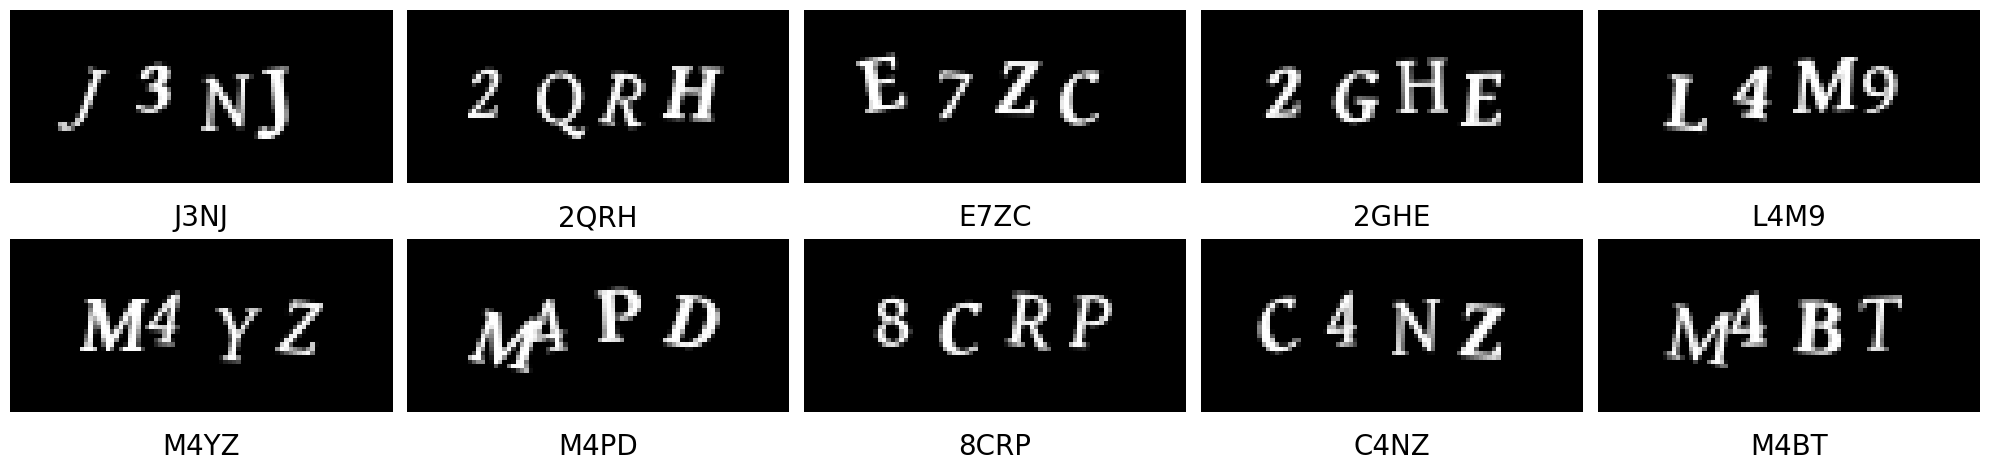

In [7]:
import cv2

def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    ## [ TODO ]
    # 1) Load image with OpenCV
    image = cv2.imread(image_path)

    # 2) Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 3) Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
# Review loaded CAPTCHAs
print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

Next, we will split our dataset into train-validation set and test set. The former set will be used for training and validation in deep character classification model, while the latter will be used for testing our CAPTCHA recognition pipline end-to-end:

In [8]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Bounding Box Extraction
It's now time to perform the most important feature extraction step: finding contours and extracting characters. Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. It is useful for shape analysis and object detection and recognition. For our task however, we are **more interested in the bounding boxes around characters**, since these are the part of images we will be used for character classification:

Here are the steps we are going to perform:

* Find contours around characters in CAPTCHAs.
* Get the position and size for each corresponding bounding box.
* If a bounding box is too wide (width-to-height ratio larger than 1.25), chances are that we have bounded two letters in a single bounding box. In this case, split the bounding box vertically from the center into two.
* Store all bounding boxes for the CAPTCHA.
* If there aren't 4 bounding boxes for the CAPTCHA, ignore it since our character extraction process must have run into problems in this case.
* Sort the bounding boxes by their X coordinates, so that they match the order corresponding letters occur.
* For each bounding box, extract corresponding region of the image, and store it as an instance of corresponding character at `${CHAR_IMAGE_FOLDER}/{letter}/{count}.png`.

After these steps, we have transformed CAPTCHA images into images of single character. This simplifies our task since now our model only needs to deal with classification (from character image to character itself) rather than also dealing with detection (finding and extracting charatcers).

In [9]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    # Loop through each contour
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the bounding box,
        # detect if there are letters conjoined into one chunk
        if w / h > 1.25:
            # Bounding box is too wide for a single character
            # Split it in half into two letter regions
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            # Only a single letter in contour
            char_regions.append((x, y, w, h))

    # Ignore image if less or more than 4 regions detected
    if len(char_regions)!=4:
        return None
    # Sort regions by their X coordinates
    char_regions.sort(key=lambda x: x[0])

    # Character images
    char_images = []
    # Save each character as a single image
    for x, y, w, h in char_regions:
        # Extract character from image with 2px margin
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        # Save character images
        char_images.append(char_image)

    # Return character images
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        # Get the folder to save the image in
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        # Write letter image to file
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        # Update count
        char_counts[char] = char_count+1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
# Extract and save images for characters
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        # Extract character images
        char_images = extract_chars(captcha_image)
        # Skip if extraction failed
        if char_images is None:
            continue
        # Save character images
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

## Label Encoding
During the training stage, we are going to load character images from previous stages as features and generate corresponding labels from their path. We will then rescale features, one-hot encode labels (occurred characters) and save labels to an external file.

In [10]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    # Resize letter to 20*20
    image_resized = resize_to_fit(image, 20, 20)
    # Add extra dimension as the only channel
    feature = image_resized[..., None]

    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    # Load image and make feature
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    # Extract label based on the directory the image is in
    label = image_path.split(os.path.sep)[-2]

    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale raw pixel values into range [0, 1]
features_tv = np.array(features_tv, dtype="float")/255
# Convert labels into one-hot encodings
lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
# Number of classes
n_classes = len(lb.classes_)

# Further split the training data into training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)
# Save mapping from labels to one-hot encoding
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

# Training
Next, we build a Convolutional Neural Network (CNN) as our classification model with Tensorflow / Keras. The structure of the neural network is shown below:

After building the neural network, we train it and save weights.

In [11]:
# Batch size
BATCH_SIZE = 32
# Number of epochs
N_EPOCHS = 10

# Path of model weights file
MODEL_WEIGHTS_PATH = "./captcha-model.weights.h5"
# Force training even if weights are already available
FORCE_TRAINING = True

# Build a feed-forward neural network
model = Sequential()

## [ TODO ]
# Implement the neural network shown above

# First convolution block: (*, 20, 20, 1) -Conv2D+ReLU-> (*, 20, 20, 20) -MaxPooling2D-> (*, 10, 10, 20)
# (Remember to include input shape for the first layer!)

# 1) Convolution layer: 20 channels, 5*5 kernel, ReLU activation, padded to maintain same shape
model.add(layers.Conv2D(20, (5, 5), padding="same", activation="relu", input_shape=(20, 20, 1)))
# 2) Max pooling layer: 2*2 kernel
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolution block: (*, 10, 10, 20) -Conv2D+ReLU-> (*, 10, 10, 50) -MaxPooling2D-> (*, 5, 5, 50)
# Convolution layer: same as above, but use 50 channels
model.add(layers.Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten layer reshape features to 1D: (*, 5, 5, 50) -Flatten-> (*, 1250)
model.add(layers.Flatten())

# First fully-connected (linear) layer: (*, 1250) -FC+ReLU -> (*, 500)
model.add(layers.Dense(500, activation="relu"))
# Last fully-connected (linear) layer: (*, 500) -FC+Softmax-> (*, n_classes)
# Softmax outputs a categorical distribution representing probability for each character
model.add(layers.Dense(n_classes, activation="softmax"))

# Build classification model with Adam optimizer and cross entropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    # Train the neural network model
    model.fit(
        X_train, y_train, validation_data=(X_vali, y_vali),
        batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1
    )
    # Save model weights to disk
    model.save_weights(MODEL_WEIGHTS_PATH)
else:
    model.load_weights(MODEL_WEIGHTS_PATH)

# Show model summary
print(model.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.2483 - loss: 2.8531 - val_accuracy: 0.9417 - val_loss: 0.3260
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9451 - loss: 0.2641 - val_accuracy: 0.9731 - val_loss: 0.1332
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9859 - loss: 0.0775 - val_accuracy: 0.9910 - val_loss: 0.0649
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.9949 - loss: 0.0320 - val_accuracy: 0.9910 - val_loss: 0.0611
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9991 - loss: 0.0098 - val_accuracy: 0.9944 - val_loss: 0.0531
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9996 - loss: 0.0081 - val_accuracy: 0.9944 - val_loss: 0.0492
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9998 - loss: 0.0042 - val_accuracy: 0.9933 - val_loss: 0.0508
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.9922 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 20, 20, 20)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 50)     │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1250)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       625,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        16,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,308 (7.63 MB)

 Trainable params: 667,102 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,334,206 (5.09 MB)

None


# Evaluation
During the training part, we have validated the performance of our neural network model on images of single characters. Now it's time to test and evaluate CAPTCHAs from the beginning to the end. First, we will need to build the pipeline for CAPTCHA character prediction:

In [12]:
# Load labels from file (so we can translate model predictions to actual letters)
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)

# Test our pipeline (and model) with the test set.
# However, you'd want to replace this with some random CAPTCHAs in the real world.

# Dummy character images
DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))

# Indices of CAPTCHAs on which extractions failed
extract_failed_indices = []
# Extracted character images
char_images_test = []

# Extract character images and make features
for i, captcha_image in enumerate(captcha_images_test):
    # Extract character images
    char_images = extract_chars(captcha_image)

    if char_images:
        char_images_test.extend(char_images)
    # Use dummy character images as placeholder if extraction failed
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

# Make features for character images
features_test = [make_feature(char_image) for char_image in char_images_test]
# Scale raw pixel values into range [0, 1]
features_test = np.array(features_test, dtype="float")/255

# Make features for character images
features_test = [make_feature(char_image) for char_image in char_images_test]
# Scale raw pixel values into range [0, 1]
features_test = np.array(features_test, dtype="float")/255
# Predict labels with neural network
preds_test = model.predict(features_test)
# Convert one-hot encoded characters back
preds_test = lb.inverse_transform(preds_test)

# Group all 4 characters for the same CAPTCHA
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]
# Update result for CAPTCHAs on which extractions failed
for i in extract_failed_indices:
    preds_test[i] = "-"

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


Now, we can compute the accuracy of our pipeline, as well as taking a look at correct and incorrect CAPTCHA text predictions:

# of test CAPTCHAs: 228
# correctly recognized: 219
Accuracy: 0.9605263157894737 

Figure(2000x500)
Figure(2000x600)


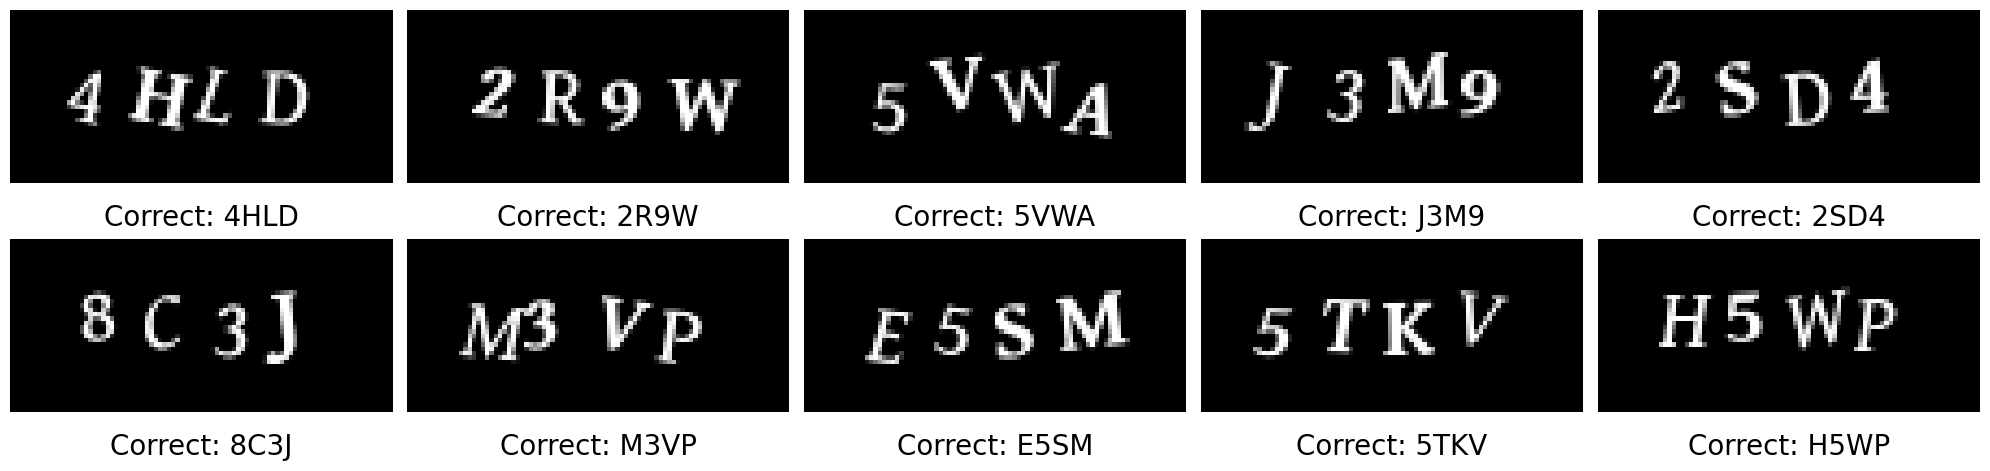

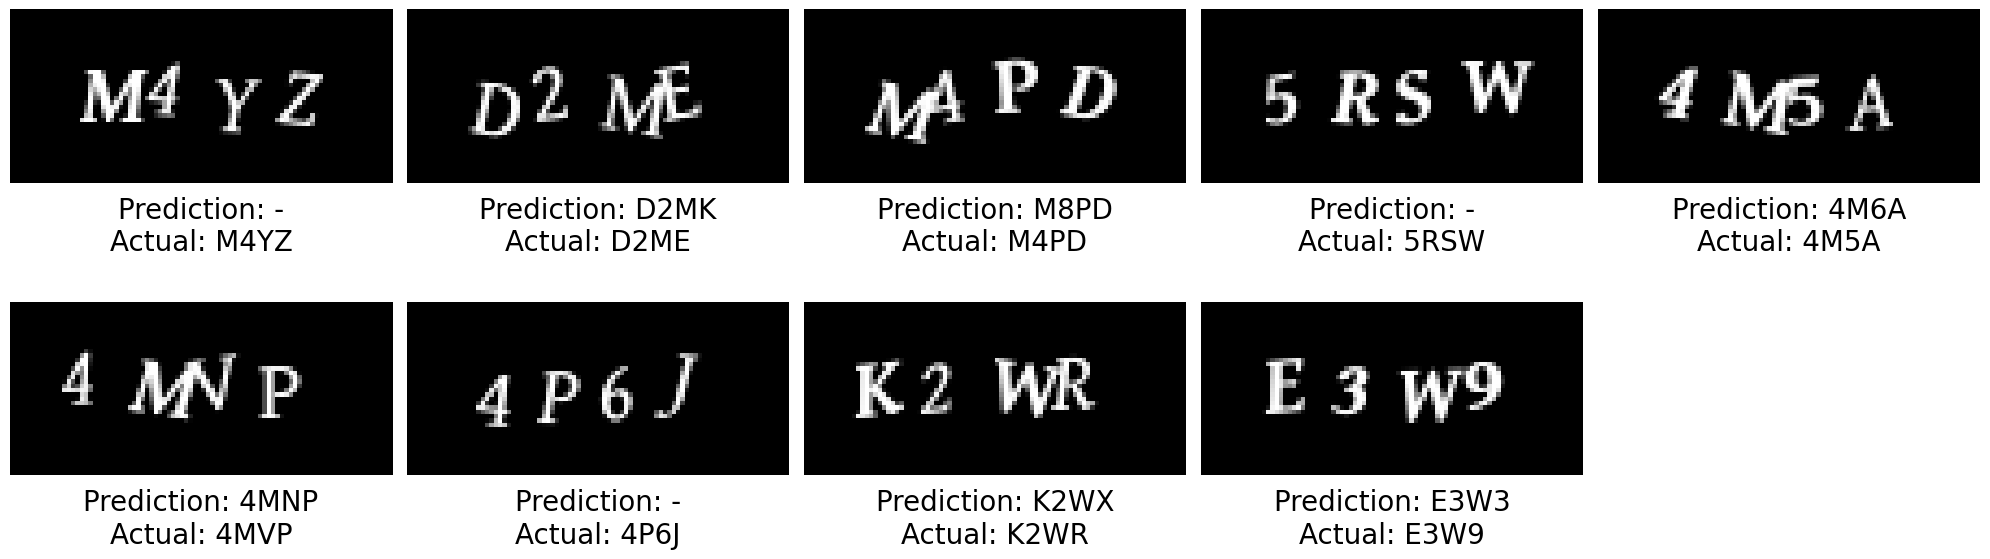

In [13]:
# Number of CAPTCHAs to display
N_DISPLAY_SAMPLES = 10

# Number of test CAPTCHAs
n_test = len(captcha_texts_test)
# Number of correct predictions
n_correct = 0

# Indices of correct predictions
correct_indices = []
# Indices of incorrect predictions
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text==actual_text:
        # 1) Update number of correct predictions
        n_correct += 1
        # 2) Collect index of correct prediction
        if len(correct_indices)<N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        # 3) Collect index of incorrect prediction
        if len(incorrect_indices)<N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

# Show number of total / correct predictions and accuracy
print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct/n_test, "\n")

# Show all correct predictions
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

# Show all incorrect predictions
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" \
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

### Open-Ended Extension:

TensorFlow is one popular framework for implementing Deep Neural Networks, and another widely used framework is **PyTorch**. After you successfully complete this lab:

- Use your favorite language model and/or coding assistant (e.g., **GPT**, **Copilot**, **Gemini**, **Cursor**, etc.) to **convert your TensorFlow CNN implementation into PyTorch**.
- Repeat the same training + evaluation experiments in PyTorch.
- You should observe **similar results** (minor differences are expected due to randomness and implementation details).

✅ **Submission Requirement:**  
Include this as a **separate notebook** in your lab-submission GitHub repository named:

**`Breaking-CAPTCHAS-Pytorch.ipynb`**


## References
1. How to break a CAPTCHA system in 15 minutes with Machine Learning: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710
2. CaptchaSolver Jupyter Notebook: https://github.com/BenjaminWegener/CaptchaSolver
3. Keras Tutorial: The Ultimate Beginner's Guide to Deep Learning in Python: https://elitedatascience.com/keras-tutorial-deep-learning-in-python
4. Keras API reference: https://keras.io/
5. Tensorflow API reference: https://www.tensorflow.org/api_docs